<div dir="rtl">
ابتدا فایل json را می‌خوانیم و سپس برای هر خبر، title و summary و link و tags را در
لیست هایی به همین نام ذخیره می کنیم و سپس یک لیست برای دسته اصلی tags به نام main_tag و یک ایجاد می‌کنیم
و همچنین یک لیست به نام sum_tit که از اتصال کلمات summary و title ساخته می شود را ایجاد می‌کنیم.
</div>

In [161]:
import json
import hazm
with open('hamshahri.json') as f:
  data = json.load(f)
title = []
summary=[]
link = []
tags = []
main_tag = []
sum_tit = []
for item in data:
    title.append(item['title'])
    summary.append(item['summary'])
    link.append(item['link'])
    tags.append(item['tags'])
for i in range(len(summary)):
    sum_tit.append(summary[i] + " " + title[i])
for item in tags:
    s = item[0].replace("'",'')
    main_tag.append(s.split('>')[0])

<div dir="rtl">
از این تابع برای ساخت فایلی که نتیجه خوشه بندی را نشان می‌دهد استفاده می کنیم این تابع نام فایل و لیست لینک ها
 و برچسب مربوط به هر لینک را در یک لیست به عنوان ورودی دریافت کرده و فایل مورد نظر را می‌سازد.
</div>

In [162]:
import string
import csv
def create_csv(name,link,label):
    with open(name + ".csv", 'w+', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Link", "Label"])
        for i in range(len(link)):
            writer.writerow([link[i],label[i]])

<div dir="rtl">
از این تایع برای پیش پردازش متن استفاده می‌کنیم
و کلماتی که عدد و یا علائم نگارشی و یا جزو stop word فارسی باشند را از محموعه مستندات حذف می‌کنیم.
</div>

In [163]:
def clean_text(tokens):
    stop_word = hazm.stopwords_list()
    def is_not_clean(word):
        if word in string.punctuation:
            return False
        if word in '!٬٫﷼٪×،*)(ـ+=-][}{|»«:؛><؟/\\':
            return False
        if word.isdigit():
            return False
        if word in stop_word:
            return False
        if word == '':
            return False
        return True

    tokens = [value for value in tokens if is_not_clean(value)]
    return tokens

<div dir="rtl">
در این بخش برای sum_tit مستندات را به وسیله کتابخانه hazm پیش پردازش می‌کنیم.
</div>

In [164]:
from sklearn.feature_extraction.text import TfidfVectorizer
word_list = []
doc_list = []
normalizer = hazm.Normalizer()
stemmer = hazm.Stemmer()
lemmatizer = hazm.Lemmatizer()
for item in sum_tit:
    normalizer.normalize(item)
    word_list = hazm.word_tokenize(item)
    word_list = clean_text(word_list)
    for i in range(len(word_list)):
        word_list[i] = stemmer.stem(word_list[i])
        word_list[i] = lemmatizer.lemmatize(word_list[i])
    doc_list.append(word_list)

<div dir = "rtl">
در این بخش یک تابع dummy_fun که یک ورودی گرفته و همان را خروجی می‌دهد تعربف می‌کنیم از این تابع به عنوان tokenizer در
TfidfVectorizer استفاده می‌کنیم تا بتوانیم که به عنوان ورودی به آن، مستند tokenize شده را بدهیم.
</div>

In [165]:
def dummy_fun(doc):
    return doc
tfidf = TfidfVectorizer(tokenizer=dummy_fun,preprocessor=dummy_fun,token_pattern=None,analyzer='word')

<div dir = "rtl">
در این بخش مستندات برای title و summary به صورت جداگانه از طریق TF-IDF به فضای برداری تبدیل می‌کنیم.
</div>

<div dir = "rtl">
در این بخش مستندات را طریق TF-IDF به فضای برداری تبدیل می‌کنیم.
</div>

In [166]:
X_TF_IDF = tfidf.fit_transform(doc_list)

<div dir = "rtl">
مستندات را با استفاده از word2vec به فضای برداری تبدیل می‌کنیم انتخاب پارامتر ها
 به صورت تچربی و با آزمون و خطا انجام شده است word2vec برای هر کلمه یک بردار می دهد
و سپس بین این بردار ها برای هر مستند میانگین می‌گیریم و بردار برای هر مستند به دست خواهد آمد
</div>

In [167]:
from gensim.models import Word2Vec
import numpy as np
title_X_word2vec = []
summary_X_word2vec = []
w2v_model = Word2Vec(min_count=20,window=2,size=100,sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20)
w2v_model.build_vocab(doc_list)
w2v_model.train(doc_list, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
X_word2vec = []
for i in range(len(doc_list)):
    v = []
    sum_weight = 0
    for word in doc_list[i]:
        if word in list(w2v_model.wv.vocab):
            v.append(np.array(w2v_model.wv[word]))
    sum = v[0]
    for i in range(1,len(v)):
        sum += v[i]
    X_word2vec.append(np.array(sum)/len(v))

<div dir = "rtl">
الگوریتم kmeans را برای TF-IDF و word2vec اجرا می‌کنیم
 و تعداد خوشه ها را  ۱۴ که تعداد unique دسته اصلی است قرار می‌دهیم
از svd برای کاهش بعد بردار ویژگی ها استفاده می‌کنیم
و یک نمودار دوبعدی برای هر کدام رسم می‌کنیم.
<br>
و همان طور که ار نتایج خوشه بندی مشخص است word2vec بهتر از TF-IDF عمل می کند و با این که با نمودار دو بعدی خیلی
نمی‌توان در مورد دفت خوشه بندی اظهار نظر کرد ولی همان طور که در نمودار ها مشخص است خوشه بندی نسبتا خوبی انجام شده است.
</div>

TF-IDF:
adjusted_rand_score : 0.0688
adjusted_mutual_info_score: 0.2760
rand_score : 0.7169
mutual_info_score: 0.6006
word2vec:
adjusted_rand_score : 0.1080
adjusted_mutual_info_score: 0.2496
rand_score : 0.8090
mutual_info_score: 0.6037


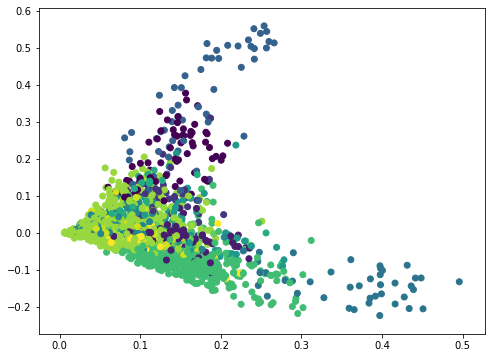

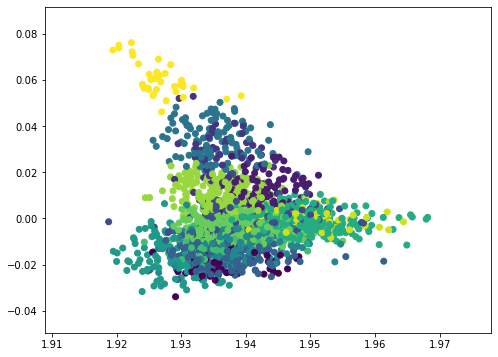

In [168]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
def Kmeans(X,name):
    km = KMeans(
        n_clusters=14, init='random',
        n_init=20
    )
    y_km = km.fit_predict(X)
    print("adjusted_rand_score : %.4f" %metrics.adjusted_rand_score(main_tag,y_km))
    print("adjusted_mutual_info_score: %.4f" %metrics.adjusted_mutual_info_score(main_tag,y_km))
    print("rand_score : %.4f" %metrics.rand_score(main_tag,y_km))
    print("mutual_info_score: %.4f" %metrics.mutual_info_score(main_tag,y_km))
    create_csv(name,link,y_km)
    tsvd = TruncatedSVD(n_components=2)
    data_2D= tsvd.fit_transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(data_2D[:,0], data_2D[:,1], c=y_km.astype(float))
tsvd = TruncatedSVD(n_components=75,n_iter=20)
X_TF_IDF_tsvd = tsvd.fit_transform(X_TF_IDF)
print("TF-IDF:")
Kmeans(X_TF_IDF_tsvd,"tf-idf_kmeans")
print("word2vec:")
Kmeans(X_word2vec,"word2vec_kmeans")

<div dir = "rtl">
الگوریتم GMM را برای TF-IDF اجرا می‌کنیم
 و تعداد خوشه ها را  ۱۴ که تعداد unique دسته اصلی است قرار می‌دهیم.
 <br>
 این الگوریتم از الگوریتم های دیگر بهتر عمل می‌کند و ARI و AMI بهتری نسبت به آن ها دارد ولی استفاده از word2vec نتیجه بهتری را برای این الگوریتم حاصل خواهد کرد.
</div>

adjusted_rand_score : 0.0894
adjusted_mutual_info_score: 0.2039
rand_score : 0.7369
mutual_info_score: 0.4462


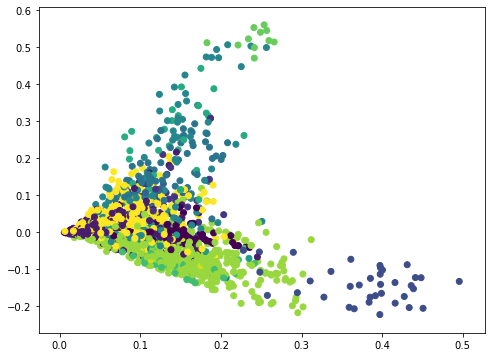

In [169]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=14, random_state=0).fit(X_TF_IDF_tsvd)
y_gm = gm.predict(X_TF_IDF_tsvd)
print("adjusted_rand_score : %.4f" %metrics.adjusted_rand_score(main_tag,y_gm))
print("adjusted_mutual_info_score: %.4f" %metrics.adjusted_mutual_info_score(main_tag,y_gm))
print("rand_score : %.4f" %metrics.rand_score(main_tag,y_gm))
print("mutual_info_score: %.4f" %metrics.mutual_info_score(main_tag,y_gm))
create_csv("tf-idf_gmm",link,y_gm)
tsvd = TruncatedSVD(n_components=2)
data_2D= tsvd.fit_transform(X_TF_IDF)
plt.figure(figsize=(8, 6))
plt.scatter(data_2D[:,0], data_2D[:,1], c=y_gm.astype(float))

<div dir = "rtl">
الگوریتم GMM را برای word2vec اجرا می‌کنیم
 و تعداد خوشه ها را  ۱۴ که تعداد unique دسته اصلی است قرار می‌دهیم.
  این الگوریتم با استفاده از word2vec بهترین نیتجه بین تمام الگوریتم ها را دارد
</div>

adjusted_rand_score : 0.1831
adjusted_mutual_info_score: 0.2749
rand_score : 0.8421
mutual_info_score: 0.6873


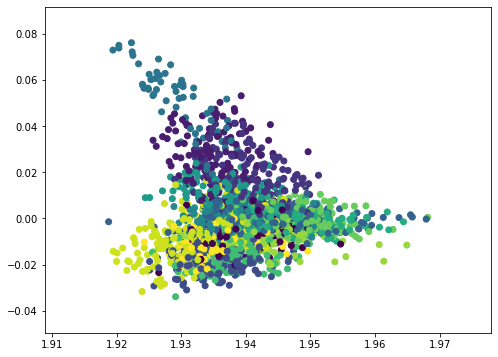

In [173]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=14).fit(X_word2vec)
y_gm = gm.predict(X_word2vec)
print("adjusted_rand_score : %.4f" %metrics.adjusted_rand_score(main_tag,y_gm))
print("adjusted_mutual_info_score: %.4f" %metrics.adjusted_mutual_info_score(main_tag,y_gm))
print("rand_score : %.4f" %metrics.rand_score(main_tag,y_gm))
print("mutual_info_score: %.4f" %metrics.mutual_info_score(main_tag,y_gm))
create_csv("word2vec_gmm",link,y_gm)
tsvd = TruncatedSVD(n_components=2)
data_2D= tsvd.fit_transform(X_word2vec)
plt.figure(figsize=(8, 6))
plt.scatter(data_2D[:,0], data_2D[:,1], c=y_gm.astype(float))

<div dir = "rtl">
الگوریتم HAC را برای TF-IDF اجرا می‌کنیم
 و تعداد خوشه ها را  ۱۴ که تعداد unique دسته اصلی است قرار می‌دهیم.
</div>

adjusted_rand_score : 0.0364
adjusted_mutual_info_score: 0.2751
rand_score : 0.6309
mutual_info_score: 0.5587


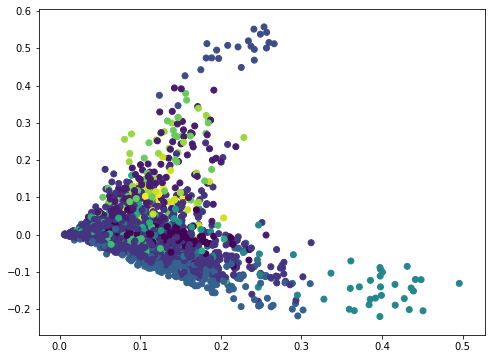

In [171]:
from sklearn.cluster import AgglomerativeClustering
y_hac = AgglomerativeClustering(n_clusters=14).fit_predict(X_TF_IDF_tsvd)
print("adjusted_rand_score : %.4f" %metrics.adjusted_rand_score(main_tag,y_hac))
print("adjusted_mutual_info_score: %.4f" %metrics.adjusted_mutual_info_score(main_tag,y_hac))
print("rand_score : %.4f" %metrics.rand_score(main_tag,y_hac))
print("mutual_info_score: %.4f" %metrics.mutual_info_score(main_tag,y_hac))
create_csv("tf-idf_HAC",link,y_hac)
tsvd = TruncatedSVD(n_components=2)
data_2D= tsvd.fit_transform(X_TF_IDF)
plt.figure(figsize=(8, 6))
plt.scatter(data_2D[:,0], data_2D[:,1], c=y_hac.astype(float))

<div dir = "rtl">
الگوریتم HAC را برای word2vec اجرا می‌کنیم
 و تعداد خوشه ها را  ۱۴ که تعداد unique دسته اصلی است قرار می‌دهیم.
 نتیجه این الگوریتم تقریبا مانند kemans است.
</div>

adjusted_rand_score : 0.1064
adjusted_mutual_info_score: 0.2573
rand_score : 0.7963
mutual_info_score: 0.6066


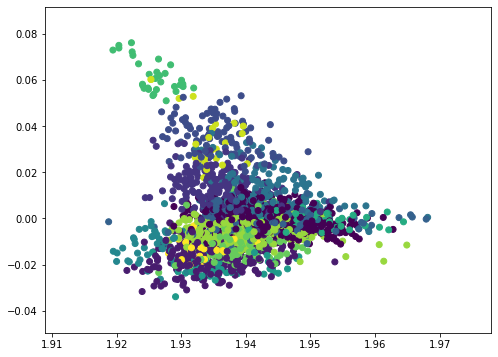

In [172]:
from sklearn.cluster import AgglomerativeClustering
y_hac = AgglomerativeClustering(n_clusters=14).fit_predict(X_word2vec)
print("adjusted_rand_score : %.4f" %metrics.adjusted_rand_score(main_tag,y_hac))
print("adjusted_mutual_info_score: %.4f" %metrics.adjusted_mutual_info_score(main_tag,y_hac))
print("rand_score : %.4f" %metrics.rand_score(main_tag,y_hac))
print("mutual_info_score: %.4f" %metrics.mutual_info_score(main_tag,y_hac))
create_csv("word2vec_HAC",link,y_hac)
tsvd = TruncatedSVD(n_components=2)
data_2D= tsvd.fit_transform(X_word2vec)
plt.figure(figsize=(8, 6))
plt.scatter(data_2D[:,0], data_2D[:,1], c=y_hac.astype(float))